# **Bounding Boxes Using the Stroke Data non Machine Learning Aproach**

In [44]:
import polars as pl
import os
import pandas as pd
import numpy as np
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import ast

In [45]:
df = pl.read_csv("/media/parker/Data_Drive/quick-draw-data/master_doodle_dataframe.csv")
df.head()

countrycode,drawing,key_id,recognized,word,image_path
str,str,i64,bool,str,str
"""RO""","""[[[0, 5, 3, 4, 10, 72, 82, 91,…",5613582005829632,true,"""traffic light""","""data/traffic light/56135820058…"
"""US""","""[[[0, 255], [3, 4]], [[86, 73,…",5769631006457856,true,"""traffic light""","""data/traffic light/57696310064…"
"""ZA""","""[[[39, 33, 34, 39, 52, 61, 66,…",4999795544424448,true,"""traffic light""","""data/traffic light/49997955444…"
"""VN""","""[[[12, 9], [128, 255]], [[0, 2…",4878417906368512,true,"""traffic light""","""data/traffic light/48784179063…"
"""HU""","""[[[9, 7, 0, 19, 49, 90, 96, 99…",5572841187573760,true,"""traffic light""","""data/traffic light/55728411875…"


In [46]:
# loading the words df which is json 
words_list = pd.read_json("words_keep.json")

In [47]:
words_list.head()

,words
0,traffic light
1,van
2,firetruck
3,tractor
4,axe


In [48]:
# cols for words list
print(words_list.columns)

Index(['words'], dtype='object')


In [49]:
# filter the df to only include the words in the words_list dataframe
filtered_df = df.filter(pl.col('word').is_in(words_list['words'].tolist()))
filtered_df.head()

# convert the filtered dataframe to a pandas dataframe
filtered_df = filtered_df.to_pandas()

In [50]:
df = filtered_df
df.head()

,countrycode,drawing,key_id,recognized,word,image_path
0,RO,"[[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...",5613582005829632,True,traffic light,data/traffic light/5613582005829632.png
1,US,"[[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...",5769631006457856,True,traffic light,data/traffic light/5769631006457856.png
2,ZA,"[[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...",4999795544424448,True,traffic light,data/traffic light/4999795544424448.png
3,VN,"[[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...",4878417906368512,True,traffic light,data/traffic light/4878417906368512.png
4,HU,"[[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...",5572841187573760,True,traffic light,data/traffic light/5572841187573760.png


In [51]:
# dropping all columns but the drawing and the word column 
df = df[['drawing', 'word']]
df.head()

,drawing,word
0,"[[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...",traffic light
1,"[[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...",traffic light
2,"[[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...",traffic light
3,"[[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...",traffic light
4,"[[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...",traffic light


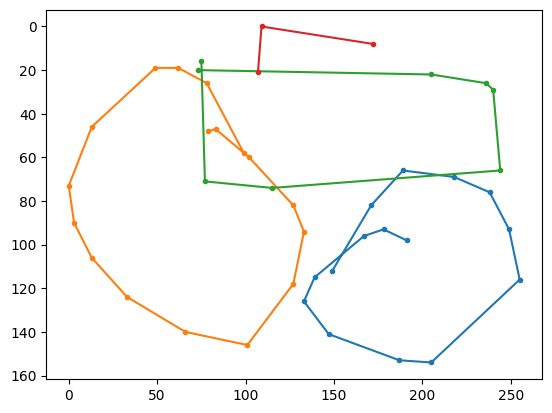

In [58]:
# plotting a random doodle
# convert the string representation of the drawing to a list
drawing = ast.literal_eval(df['drawing'].iloc[10000])

# plot the drawing
for x, y in drawing:
    plt.plot(x, y, marker='.')
plt.gca().invert_yaxis()
plt.show()

In [53]:
# function to do bounding boxes around the doodle

def get_square_bbox_with_padding(drawing_str, padding=20):
    strokes = ast.literal_eval(drawing_str)
    x_all = []
    y_all = []

    for stroke in strokes:
        x, y = stroke
        x_all.extend(x)
        y_all.extend(y)

    x_min, x_max = min(x_all), max(x_all)
    y_min, y_max = min(y_all), max(y_all)

    # determine the width and height
    width = x_max - x_min
    height = y_max - y_min
    max_dim = max(width, height)

    # center the box to make it square
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    half_dim = max_dim / 2 + padding

    # create square box
    square_x_min = int(max(x_center - half_dim, 0))
    square_x_max = int(min(x_center + half_dim, 255))  # clamp to 0–255
    square_y_min = int(max(y_center - half_dim, 0))
    square_y_max = int(min(y_center + half_dim, 255))

    return square_x_min, square_y_min, square_x_max, square_y_max

In [54]:
# applying the bounding box function to the dataframe and returning the bounding box as a new column
df['bbox'] = df['drawing'].apply(lambda x: get_square_bbox_with_padding(x, padding=20))

/tmp/ipykernel_955316/3098203445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bbox'] = df['drawing'].apply(lambda x: get_square_bbox_with_padding(x, padding=20))


In [55]:
df.head()

,drawing,word,bbox
0,"[[[0, 5, 3, 4, 10, 72, 82, 91, 99, 98, 87, 71,...",traffic light,"(0, 0, 197, 255)"
1,"[[[0, 255], [3, 4]], [[86, 73, 73, 76, 85, 130...",traffic light,"(0, 0, 255, 255)"
2,"[[[39, 33, 34, 39, 52, 61, 66, 65, 67, 71], [2...",traffic light,"(0, 0, 196, 255)"
3,"[[[12, 9], [128, 255]], [[0, 23, 36, 37, 42, 5...",traffic light,"(0, 0, 181, 255)"
4,"[[[9, 7, 0, 19, 49, 90, 96, 99, 93, 94, 62, 16...",traffic light,"(0, 0, 197, 255)"


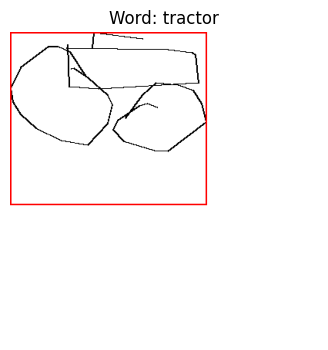

In [ ]:
# function to visualize the doodle with the bounding box

def visualize_doodle_with_bbox(drawing_str, bbox, canvas_size=400, stroke_width=2): ### you can adjust the canvas size, so you could change it to 256 or whatever you want
    strokes = ast.literal_eval(drawing_str)

    # blank canvas
    img = Image.new("RGB", (canvas_size, canvas_size), color="white")
    draw = ImageDraw.Draw(img)

    # draw the stokes
    for stroke in strokes:
        x, y = stroke
        points = list(zip(x, y))
        draw.line(points, fill="black", width=stroke_width)

    # draw the bounding box
    draw.rectangle(bbox, outline="red", width=2)

    return img



# select a random row from the df using 3000 to match the previous example plot
example_row = df.iloc[10000]
img = visualize_doodle_with_bbox(example_row['drawing'], example_row['bbox'])

# show the image
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Word: {example_row['word']}")
plt.show()

## This cell below allows you to draw a bounding box around the stroke data that you draw. **Do not move the box once the image drawing area shows up, this causes some sort of error and draws an line randomly**

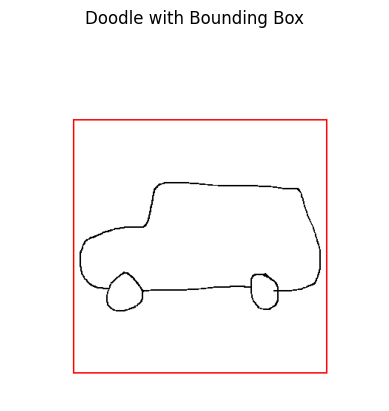

In [ ]:
import tkinter as tk
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

strokes = []  # list of the strokes
current_stroke = ([], [])

def start_stroke(event):
    current_stroke[0].append(event.x)
    current_stroke[1].append(event.y)

def draw_stroke(event):
    canvas.create_line(event.x, event.y, event.x + 1, event.y + 1)
    current_stroke[0].append(event.x)
    current_stroke[1].append(event.y)

def end_stroke(event):
    global strokes
    strokes.append((current_stroke[0][:], current_stroke[1][:]))
    current_stroke[0].clear()
    current_stroke[1].clear()

def get_square_bbox_with_padding(strokes, padding=20):
    x_all = []
    y_all = []

    for x, y in strokes:
        x_all.extend(x)
        y_all.extend(y)

    x_min, x_max = min(x_all), max(x_all)
    y_min, y_max = min(y_all), max(y_all)

    width = x_max - x_min
    height = y_max - y_min
    max_dim = max(width, height)

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    half_dim = max_dim / 2 + padding

    square_x_min = int(max(x_center - half_dim, 0))
    square_x_max = int(min(x_center + half_dim, canvas_size))
    square_y_min = int(max(y_center - half_dim, 0))
    square_y_max = int(min(y_center + half_dim, canvas_size))

    return square_x_min, square_y_min, square_x_max, square_y_max

def submit():
    # draw stokes and bounding box
    img = Image.new("RGB", (canvas_size, canvas_size), "white")
    draw = ImageDraw.Draw(img)

    for x, y in strokes:
        points = list(zip(x, y))
        draw.line(points, fill="black", width=2)

    # calculate bounding box
    bbox = get_square_bbox_with_padding(strokes, padding=10)
    draw.rectangle(bbox, outline="red", width=2)

    # show image with bounding box
    plt.imshow(img)
    plt.axis('off')
    plt.title("Doodle with Bounding Box")
    plt.show()
    
"""
    # saving the stoke data
    with open("my_drawing_strokes.txt", "w") as f:
        f.write(str(strokes))

    print("drawing and bounding box complete!")
"""


# setting up the tkinter canvas area
canvas_size = 500
root = tk.Tk()
root.title("Draw something!")

canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="white")
canvas.pack()

canvas.bind("<Button-1>", start_stroke)
canvas.bind("<B1-Motion>", draw_stroke)
canvas.bind("<ButtonRelease-1>", end_stroke)

submit_button = tk.Button(root, text="Submit", command=submit)
submit_button.pack(pady=10)

root.mainloop()